# Simulation Molecular Traffic Jam

Simulation of traffic jam formation with molecular motors on a microtubule based on the Gillespie algorithm. 

<img src="Fig_model.png">


Relevant publications:
* Leduc et al. (2012). "Molecular crowding creates traffic jams of kinesin motors on microtubules." PNAS 109(16): 6100-6105



In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
import sys
import os
from datetime import date
from time import strftime
import timeit
from parameters import ParameterSet
from IPython.display import clear_output
import multiprocessing

## Define simulation parameters


In [22]:
# Dictionary to store all simulation parameters
simParameters = {}

# Store data
simParameters['record_data'] = False

# Scan parameters 
# 0 = no scan; 1 = concentration, 2 = microtubule length
simParameters['Scan'] = 2 
simParameters['Scan_num'] = 5 # number of values to scan

# Determine type of dynein: 'WT' (Wild-Type) or 'SP' (Super-Processive)
simParameters['Type'] = 'SP'
simParameters['Conc'] = 1 # Dynein concentration in nM
simParameters['Conc_range'] = [-2, 1] # Range of concentrations in logspace (in nM)

# Basic lattice unit is size of motor step, for dynein the step size is 24 nm
simParameters['step'] = 24

simParameters['L'] = 100 # Length lattice in hopping units
simParameters['L_range'] = [30, 100] # Range of lattice sizes

# Simulation duration limits
simParameters['R_max'] = 20000 # Maximum number of simulation steps
simParameters['T_max'] = 300 # Max simulated time (in seconds)
simParameters['MTs'] = 50 # Number of traffic jams to simulate

# Determine the sampling interval for saving the lattice configuration
# If sampling = 0, then only the last state will be saved. Otherwise, it
# determines the time interval (in seconds) at which to sample the output.
simParameters['sampling'] = 1

## Define characteristics of the molecular motor

The runlength and velocity parameters for the dynein are taken from Cho et al. JCB 2008.  

Wild type yeast dynein:
* Runlength = 2.25 ± 0.14 um
* Velocity  = 73.9 ± 34.2 nm/sec  

Super processive yeast dynein:
* Runlength = 4.39 ± 0.45 um
* Velocity  = 60.6 ± 18.9 nm/sec

In [23]:
# Dynein specific parameters
if simParameters['Type'] == 'WT':
    simParameters['k_on'] = 0.0025 # Attachment rate [/nM/sec]
    simParameters['k_off'] = 73.9/2250 # Detachment rate bulk [/sec]
    simParameters['k_off_end'] = simParameters['k_off'] # Detachment rate end lattice [/sec]
    simParameters['k_hop'] = 73.9/simParameters['step'] # Forward hopping rate [sites/sec]        
    
elif simParameters['Type'] == 'SP':
    simParameters['k_on'] = 0.0025 # Attachment rate [/nM/sec]
    simParameters['k_off'] = 60.6/4390 # Detachment rate bulk [/sec]
    simParameters['k_off_end'] = simParameters['k_off'] # Detachment rate end lattice [/sec]
    simParameters['k_hop'] = 60.6/simParameters['step'] # Forward hopping rate [sites/sec]  

In [24]:
simPa = ParameterSet(simParameters)

In [5]:
# Set default folder
ROOT  = os.getcwd()

sys.path.insert(0, ROOT)

# Setup data recording
if simPa.record_data:
    DATE = str(date.today())
    TIME = str(strftime('%X'))
    TIME = TIME.replace(':','-')
    
    foldername = '.\\SIM_RUNS\\'+ DATE + '__' + TIME
    os.makedirs(foldername)

### Function to calculate the propensity of each event

Event 1) Attachment of a particle to an empty spot    
Event 2) Detachment of a particle from an occupied spot   
Event 3) Detachment of a particle from the lattice end  
Event 4) Forward hopping  
 

In [6]:
# Function: Probability of each event
def probability(rates, lattice):
    
    N_events = np.zeros(4)
    Location_events = [None]*4
    
    # Empty sites    
    N_events[0] = (lattice == 0).sum()
    Location_events[0] = np.nonzero(lattice == 0)[0]
    
    # Occupied sites (excluding lattice end)
    N_events[1] = (lattice[:-1] == 1).sum()
    Location_events[1] = np.nonzero(lattice[:-1] == 1)[0]
    
    # Lattice end occupation
    N_events[2] = (lattice[-1] == 1).sum()
    Location_events[2] = np.nonzero(lattice[-1] == 1)[0]
    
    # Forward hopping events
    D_events = np.diff(lattice)
    N_events[3] = (D_events == -1).sum()    
    Location_events[3] = np.nonzero(D_events == -1)[0]
    
    # Calculate propensities of each event
    pp = np.multiply(rates, N_events)
        
    return Location_events, pp  

### Function to update lattice state


In [7]:
# Function: update state of lattice
def updateState(event, selection, state):
    
    # Attachment event       
    if event == 0:
        index = np.random.randint(len(selection))
        state[selection[index]] += 1
            
    # Detachment event lattice
    elif event == 1:
        index = np.random.randint(len(selection))
        state[selection[index]] -= 1
                    
    # Detachment event lattice end
    elif event == 2:
        state[-1] -= 1

    # Forward hopping event
    elif event == 3:
        index = np.random.randint(len(selection))
        state[selection[index]] -= 1
        state[selection[index]+1] += 1
       
    return state

### Function to sample the simulated data

In [8]:
# Sample output data
def sampleData(data, simPa):    
    
    # Input
    lattice = data[0]
    time = data[1]
        
    # Output
    Sampled_data = []
    L_out = []
    T_out = []
            
    if simPa.sampling == 0: # Only save the final state
        Sampled_data.append(lattice[-1])
        Sampled_data.append(time[-1])
    else:
        Sampled_time = np.arange(1, simPa.T_max)
        for dt in Sampled_time:
            ind = np.where(time <= dt)[0][-1]        
            L_out.append(lattice[ind])
            T_out.append(time[ind])

        Sampled_data.append(L_out)
        Sampled_data.append(T_out)
    
    return Sampled_data

### Function: Gillespie simulation

In [20]:
def gillespie(simPa):            
    
    # Extract simulation parameters
    rates = [simPa.Conc*simPa.k_on, simPa.k_off, simPa.k_off_end, simPa.k_hop]

    # Initialize simulation
    R_counter = 0
    tt = 0

    # Initialize output
    lattice_cont = [np.zeros(simPa.L)]
    tt_cont = np.zeros(1)

    # Draw randum numbers
    rand_nums = np.random.rand(2,simPa.R_max)

    # Run Gillespie simulation
    while simPa.R_max > R_counter and simPa.T_max+1 > tt:
         
        # Calculate probability for all events
        state = lattice_cont[R_counter]
        [Position_events, pp] = probability(rates, state)

        # Draw waiting time
        delta_t = -np.log(rand_nums[0][R_counter]) / np.sum(pp)

        # Construct intervals
        valid_inds = pp > 0 # Find the possible events
        valid_pp = pp[valid_inds] # Include only valid events
        valid_changes = np.nonzero(valid_inds)[0]       
        
        # Stop current simulation if no valid changes are possible
        if len(valid_changes) == 0:
            break   

        # Construct intervals
        selection_interval = np.cumsum(valid_pp) # Cumulative sum
        selection_interval = selection_interval/selection_interval[-1] # Normalize to [0,1]

        # Select interval
        selected_ind = np.nonzero(selection_interval > rand_nums[1][R_counter])[0][0]
        update_ind = Position_events[valid_changes[selected_ind]]

        # Update lattice configuration
        state_new = updateState(valid_changes[selected_ind], update_ind, state)
        lattice_cont = np.vstack((lattice_cont, state_new))

        # Update time and simulation counter
        tt += delta_t
        tt_cont = np.append(tt_cont, tt)
        R_counter +=1
        
    return lattice_cont, tt_cont              

### Actual Simulation

In [ ]:
# Run simulations
SIM_results = []

# Initialize progress report
start = timeit.default_timer()

for runs in range(simPa.MTs):

    clear_output(wait=True)
    
    [L, T] = gillespie(simPa)    
    
    # Sample data
    Sampled_data = sampleData([L,T], simPa)  
    
    # Store results
    SIM_results.append(Sampled_data)
            
    # Update progress report
    print("Current progress:",np.round((runs+1)/simPa.MTs *100, 2),"%")          

In [18]:
Var = np.round(np.linspace(simPa.L_range[0], simPa.L_range[1], num=simPa.Scan_num, dtype=int))
print(Var)

[ 30  97 165 232 300]


In [25]:
# Run simulations
results = []
SIM_results = []

# Setup parameter scanning
if simPa.Scan == 0:
    Var = [0]
elif simPa.Scan == 1: # Concentration scan
    Var = np.round(np.logspace(simPa.Conc_range[0], simPa.Conc_range[1], num=simPa.Scan_num),3)        
elif simPa.Scan == 2: # Microtubule length scan
    Var = np.round(np.linspace(simPa.L_range[0], simPa.L_range[1], num=simPa.Scan_num, dtype=int))
        
# Initialize progress report
# start = timeit.default_timer()
for val in range(len(Var)):       
    
    # Update parameter
    if simPa.Scan == 1:
        simPa.Conc = Var[val]
    elif simPa.Scan == 2:
        simPa.L = Var[val]
        
    for runs in range(simPa.MTs):

        clear_output(wait=True)

        [L, T] = gillespie(simPa)    

        # Sample data
        Sampled_data = sampleData([L,T], simPa)  

        # Store results
        results.append(Sampled_data)

        # Update progress report
        print("Total progress:",np.round((val+1)/len(Var) *100, 2),"%")
        print("Current progress:",np.round((runs+1)/simPa.MTs *100, 2),"%")       
        
    SIM_results.append(results)

Total progress: 80.0 %
Current progress: 100.0 %


In [82]:
# print(SIM_results[0][0][0])
len(SIM_results[0][0][0].size)

AttributeError: 'list' object has no attribute 'size'

In [ ]:
# Save Data
if simPa.record_data:            
    filename = foldername + '\\' + 'SIM-RUN.data'
       
    with open(filename, 'wb') as filehandle:
        pickle.dump(SIM_results, filehandle)

### Data analysis

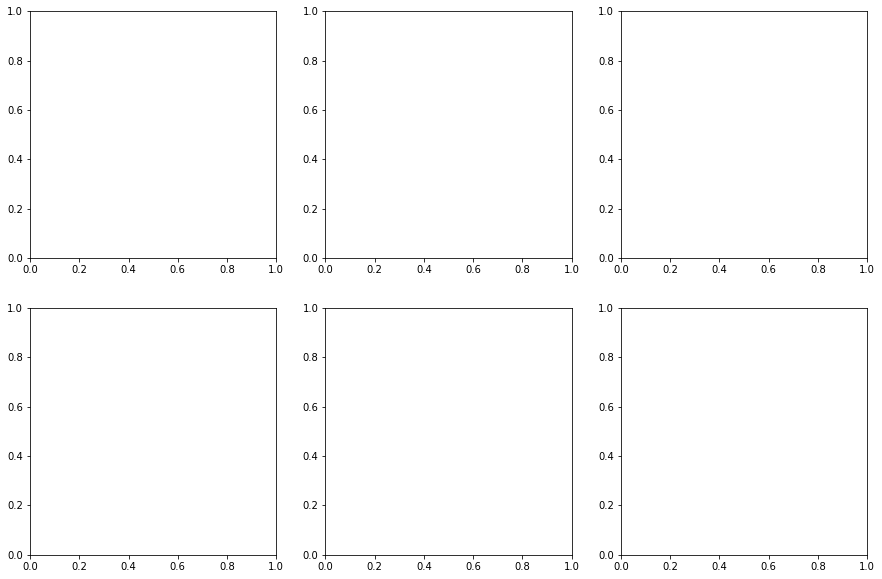

In [67]:
rows = int(np.ceil(simPa.Scan_num/3))
cols = 3
fig, axs = plt.subplots(rows, cols, figsize = (15,rows*5))

# Scan number
sc = 0
# for sc in range(simPa.Scan_num):
    # Prepare data
lattice = np.array(SIM_results[sc][0][0])
time = np.array(SIM_results[sc][0][1])
X = np.arange(0, lattice.shape[1])
X = X * (simPa.step/1000) # change units to um
Y = np.arange(0, lattice.shape[0])
X, Y = np.meshgrid(X, Y)

# Prepare mean data from all simulations
data = np.array(SIM_results[sc])
arrays = [data[x][0] for x in range(len(data))]
# Z_mean = np.mean(arrays, axis=0)
    
# axs[sc%rows, sc%cols].contourf(X, Y, Z_mean, 15,  cmap='RdGy')
#     axs[sc%rows, sc%cols].set_ylim(time[-1],0)
    

In [74]:
sc = 0
data = np.array(SIM_results)
data[0].shape
# arrays = [data[x][0] for x in range(len(data))]
# Z_mean = np.mean(arrays, axis=1)
# print(data.shape)

(250, 2, 299)

In [ ]:
# Plot kymographs: single simulation and mean 
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))

# Prepare data from single simulation.
sim_nr = 0
lattice = np.array(SIM_results[sim_nr][0])
time = np.array(SIM_results[sim_nr][1])

X = np.arange(0, lattice.shape[1])
X = X * (simPa.step/1000) # change units to um
Y = np.arange(0, lattice.shape[0])
X, Y = np.meshgrid(X, Y)
Z = lattice

# Prepare mean data from all simulations
arrays = [np.array(SIM_results[x][0]) for x in range(len(SIM_results))]
Z_mean = np.mean(arrays, axis=0)

# Plot the filled contour from single simulation.
ax1.contourf(X, Y, Z, cmap='Greys')
# ax1.set_xlim(X[0][-1],0)
ax1.set_ylim(time[-1],0)
ax1.set_xlabel('Length ($\mu$m)', fontsize=13)
ax1.set_ylabel('Time (s)', fontsize=13)
ax1.set_title('Kymograph single', fontsize=15)

# Plot the filled contour from single simulation.
Csf = ax2.contourf(X, Y, Z_mean, 25,  cmap='RdGy' )
fig.colorbar(Csf, ax=ax2)

# Extract contour lines
# cs = plt.contour(X, Y, Z_mean, 1, colors='black');
# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# x_contour = v[:,0]
# y_contour = v[:,1]

# ax2.contour(X, Y, Z_mean, 2)
# ax2.set_xlim(X[0][-1],0)
ax2.set_ylim(time[-1],0)
ax2.set_xlabel('Length ($\mu$m)', fontsize=13)
ax2.set_ylabel('Time (s)', fontsize=13)
ax2.set_title('Kymograph mean (N=' + str(simPa.MTs) + ')', fontsize=15)

plt.show()

In [ ]:
# Plot mean distribution of lattice occupation 

fig, (ax1,ax2) = plt.subplots(1,2 ,figsize = (15,5))

# Prepare data steady-state duration
arrays = [np.array(SIM_results[x][0]) for x in range(len(SIM_results))]
Z_mean = np.mean(arrays, axis=0)



ax1.plot()


# Prepare data mean density
X = np.arange(0, len(np.array(SIM_results[sim_nr][0][0])))
X = X * (simPa.step/1000) # change units to um
density_final = [np.array(SIM_results[x][0][-1]) for x in range(len(SIM_results))]
Y = np.mean(density_final, axis=0)

ax2.plot(X,Y)
ax2.set_xlabel('Length ($\mu$m)', fontsize=13)
ax2.set_ylabel('Motor density' , fontsize=13)
ax2.set_title('Mean motor density (N= ' + str(simPa.MTs) + ')', fontsize = 15)

plt.show()